In [45]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [46]:
T = 0.1
s = ctl.TransferFunction.s

In [47]:
G = 78256.395/(s**2 + 804188.372*s - 1827439.3839)
C = (41.3924173679627*s**2 + 830.102223636614*s + 637.62793024764)/(s**2 + 20*s)

G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([ 3239221.36355215, 64960807.50328521, 49898463.17249177]), array([1.00000000e+00, 8.04208372e+05, 1.74955494e+07, 2.84120198e+07,
       4.98984632e+07]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [48]:
G_z = ctl.c2d(G, T, method='zoh')
G_z

TransferFunction(array([1.09252969e-02, 1.51876112e-07]), array([ 1.        , -1.25513053,  0.        ]), 0.1)

In [49]:
C_z = ctl.c2d(C, T, method='tustin')
C_z

TransferFunction(array([ 42.24579919, -39.79834754,   0.74068801]), array([ 1., -1.,  0.]), 0.1)

In [50]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([ 4.61547897e-01, -4.34802345e-01,  8.08619192e-03,  1.12492814e-07]), array([ 1.00000000e+00, -1.79358263e+00,  8.20328182e-01,  8.08619192e-03,
        1.12492814e-07]), 0.1)

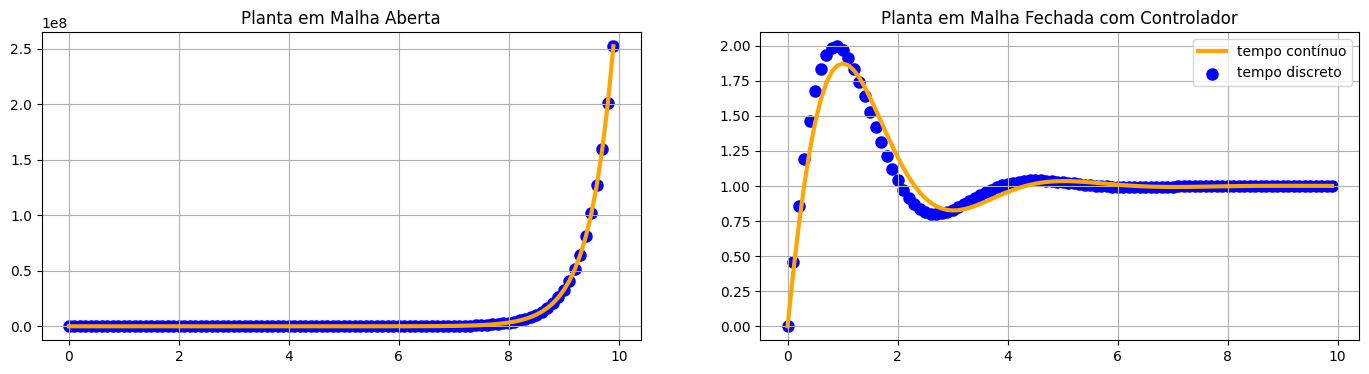

In [51]:
tData = np.arange(0, 10, T)
plt.figure(figsize=(17, 4))

plt.subplot(1, 2, 1)
time, continuous = ctl.step_response(G, T=tData)
time, digital    = ctl.step_response(G_z, T=tData)
plt.scatter(time, continuous, color='blue', linewidth=3, label='tempo discreto')
plt.plot(time, digital, color='orange', linewidth=3, label='tempo contínuo')
plt.title('Planta em Malha Aberta')
plt.grid()

plt.subplot(1, 2, 2)
time, continuous = ctl.step_response(G_feedback, T=tData)
time, digital    = ctl.step_response(G_z_feedback, T=tData)
plt.plot(time, continuous, color='orange', linewidth=3, label='tempo contínuo')
plt.scatter(time, digital, color='blue', linewidth=3, label='tempo discreto')
plt.title('Planta em Malha Fechada com Controlador')
plt.legend()
plt.grid()

# DIGITALIZANDO O SISTEMA
- Preparando as funções que permitem digitalizar a função de transferência em transformada $Z$
    - **getOutputString**: Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada
    - **resetSystem**: reinicia as variáveis globais do sistema
    - **compute**: aplica a função digitalizada a partir dos estados anteriores

In [52]:
def getOutputString(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = [num]

    out = ''

    for i in range(0, len(num)):
        out += f'{num[i]}*X_n{i} + '

    for i in range(1, len(den)):
        out += f'+ {-1*den[i]}*Y_n{i}'

    return out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')


def resetSystem():
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3
    Y_n1 = Y_n2 = Y_n3 = 0
    X_n1 = X_n2 = X_n3 = 0


def compute(X_n):
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3
    Y_n = eval(out)

    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n


out = getOutputString(G_z)
out

'0.01092529685097543*X_n + 1.5187611176488998e-07*X_n1 + 1.2551305268995534*Y_n1-0.0*Y_n2'

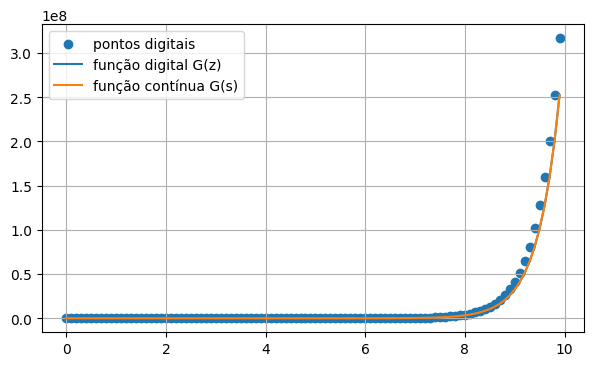

In [53]:
plt.figure(figsize=(7, 4))
time = np.arange(0, 10, T)

step = 1
resetSystem()

response = [compute(step) for i in time]
plt.scatter(time, response, label='pontos digitais')

time, response = ctl.step_response(G_z, T=time)
plt.plot(time, response, label='função digital G(z)')

time, response = ctl.step_response(G, T=time)
plt.plot(time, response, label='função contínua G(s)')
plt.grid()
plt.legend()

# DIGITALIZANDO O CONTROLADOR
- Comparando os dados contínuo e digital de forma gráfica através de um step

In [54]:
def control(input, setpoint):
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3

    X_n = setpoint - input
    Y_n = eval(out)

    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n


out = getOutputString(C_z)
out

'42.24579918770625*X_n -39.7983475423436*X_n1 + 0.7406880058755513*X_n2 + 1.0*Y_n1-0.0*Y_n2'

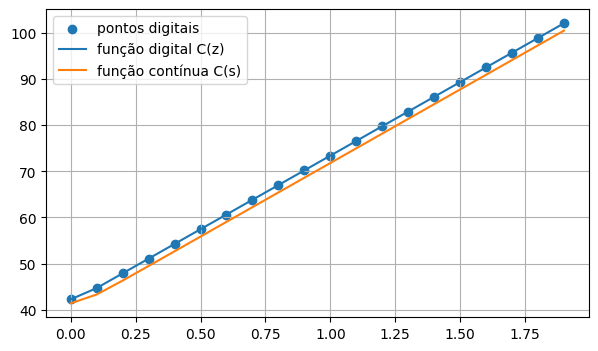

In [55]:
plt.figure(figsize=(7, 4))
time = np.arange(0, 2, T)

resetSystem()
response = [control(input=1, setpoint=2) for i in time]
plt.scatter(time, response, label='pontos digitais')

time, response = ctl.step_response(C_z, T=time)
plt.plot(time, response, label='função digital C(z)')

time, response = ctl.step_response(C, T=time)
plt.plot(time, response, label='função contínua C(s)')
plt.grid()
plt.legend()

# SIMULANDO SISTEMA
- O controlador envia um sinal $out$ para a planta, que gera um outro sinal, que é comparado com o setpoint e enviado de novo ao controlador

In [56]:
gout = getOutputString(G_z).replace('*X', '*GX').replace('*Y', '*GY')
cout = getOutputString(C_z).replace('*X', '*CX').replace('*Y', '*CY')

def compute(input):
    global GY_n1, GY_n2, GY_n3
    global GX_n1, GX_n2, GX_n3

    GX_n = input
    Y_n = eval(gout)

    GX_n3 = GX_n2
    GX_n2 = GX_n1
    GX_n1 = GX_n

    GY_n3 = GY_n2
    GY_n2 = GY_n1
    GY_n1 = Y_n
    return Y_n

def control(input, setpoint):
    global CY_n1, CY_n2, CY_n3
    global CX_n1, CX_n2, CX_n3
    global bounds

    CX_n = setpoint - input
    Y_n = eval(cout)

    CX_n3 = CX_n2
    CX_n2 = CX_n1
    CX_n1 = CX_n

    CY_n3 = CY_n2
    CY_n2 = CY_n1
    CY_n1 = Y_n

    if Y_n > bounds[1]: Y_n = bounds[1]
    if Y_n < bounds[0]: Y_n = bounds[0]

    return Y_n

print(gout)
print(cout)

0.01092529685097543*GX_n + 1.5187611176488998e-07*GX_n1 + 1.2551305268995534*GY_n1-0.0*GY_n2
42.24579918770625*CX_n -39.7983475423436*CX_n1 + 0.7406880058755513*CX_n2 + 1.0*CY_n1-0.0*CY_n2


In [61]:
CY_n1 = CY_n2 = CY_n3 = 0
CX_n1 = CX_n2 = CX_n3 = 0
GY_n1 = GY_n2 = GY_n3 = 0
GX_n1 = GX_n2 = GX_n3 = 0

bounds = (-99999, 99999)

setpoint = 10
output   = 0
tData = []
yData = []
iData = []

for time in np.arange(0, 10, T):
    input  = compute(output)
    output = control(input, setpoint)

    tData.append(time)
    iData.append(input)
    yData.append(output)


time = np.linspace(0, tData[-1], 1000)
time, desired = ctl.step_response(setpoint*G_feedback, T=time)
np.array(yData[:10])

array([ 422.45799188,  251.94791068,  106.49788363,  -27.21721119,
       -146.35079665, -249.16030957, -334.74776627, -402.95504908,
       -454.24929315, -489.60531388])

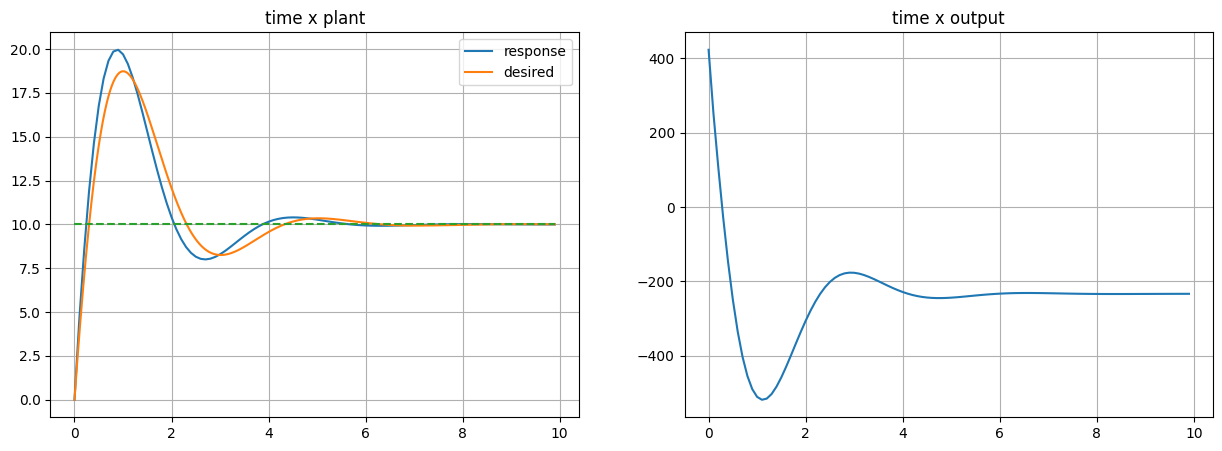

In [62]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(tData, iData, label='response')
plt.plot(time, desired, label='desired')
plt.plot(tData, [setpoint for i in tData], '--')
plt.title('time x plant')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(tData, yData)
plt.title('time x output')
plt.grid()